<a href="https://colab.research.google.com/drive/1gP00Er7dvemB9cJgGWHwcaj4ilJ8wJN3?usp=sharing" target="_blank">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab"/>
</a>

In [10]:
# 1. Setup & Imports
%load_ext tensorboard

import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import os
import datetime

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [11]:
# 2. Load California Housing Dataset
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

housing = fetch_california_housing()
X_train_full, X_test, y_train_full, y_test = train_test_split(
    housing.data, housing.target.reshape(-1, 1), random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_full, y_train_full, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)
X_test_scaled = scaler.transform(X_test)

In [12]:
# 3. Define Model
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=X_train.shape[1:]),
    keras.layers.Dense(1)
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [13]:
# 4. Define Custom Manual Momentum Optimizer (Not subclassing keras.Optimizer)
class MyManualMomentumOptimizer:
    def __init__(self, model, learning_rate=0.01, momentum=0.9):
        self.model = model
        self.lr = learning_rate
        self.momentum = momentum
        self.velocities = [
            tf.Variable(tf.zeros_like(w), trainable=False)
            for w in model.trainable_variables
        ]

    def apply_gradients(self, grads):
        for v, grad, weight in zip(self.velocities, grads, self.model.trainable_variables):
            v.assign(self.momentum * v - (1 - self.momentum) * grad)
            weight.assign_add(self.lr * v)

In [14]:
# 5. Define Training Loop with Custom Optimizer

loss_fn = keras.losses.MeanSquaredError()
n_epochs = 20
batch_size = 32
n_steps = len(X_train_scaled) // batch_size

train_dataset = tf.data.Dataset.from_tensor_slices((X_train_scaled, y_train)).shuffle(1000).batch(batch_size)
valid_dataset = tf.data.Dataset.from_tensor_slices((X_valid_scaled, y_valid)).batch(batch_size)

optimizer = MyManualMomentumOptimizer(model, learning_rate=0.01, momentum=0.9)

train_losses, valid_losses = [], []

for epoch in range(n_epochs):
    print(f"Epoch {epoch + 1}/{n_epochs}")
    epoch_loss = keras.metrics.Mean()

    for X_batch, y_batch in train_dataset:
        with tf.GradientTape() as tape:
            y_pred = model(X_batch, training=True)
            loss = loss_fn(y_batch, y_pred)
        grads = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(grads)
        epoch_loss.update_state(loss)

    train_loss = epoch_loss.result().numpy()
    train_losses.append(train_loss)

    # Validation loss
    y_valid_pred = model.predict(X_valid_scaled, verbose=0)
    valid_loss = loss_fn(y_valid, y_valid_pred).numpy()
    valid_losses.append(valid_loss)

    print(f"  ➤ Train Loss: {train_loss:.4f} - Val Loss: {valid_loss:.4f}")


Epoch 1/20
  ➤ Train Loss: 0.8375 - Val Loss: 0.5554
Epoch 2/20
  ➤ Train Loss: 0.5123 - Val Loss: 14.6118
Epoch 3/20
  ➤ Train Loss: 0.4632 - Val Loss: 16.6730
Epoch 4/20
  ➤ Train Loss: 0.4745 - Val Loss: 4.7831
Epoch 5/20
  ➤ Train Loss: 0.4369 - Val Loss: 0.7182
Epoch 6/20
  ➤ Train Loss: 0.4070 - Val Loss: 0.4176
Epoch 7/20
  ➤ Train Loss: 0.3985 - Val Loss: 0.3818
Epoch 8/20
  ➤ Train Loss: 0.3920 - Val Loss: 0.3610
Epoch 9/20
  ➤ Train Loss: 0.3867 - Val Loss: 0.3648
Epoch 10/20
  ➤ Train Loss: 0.3839 - Val Loss: 0.3648
Epoch 11/20
  ➤ Train Loss: 0.3835 - Val Loss: 0.3593
Epoch 12/20
  ➤ Train Loss: 0.3763 - Val Loss: 0.3456
Epoch 13/20
  ➤ Train Loss: 0.4410 - Val Loss: 0.3498
Epoch 14/20
  ➤ Train Loss: 0.3760 - Val Loss: 0.3505
Epoch 15/20
  ➤ Train Loss: 0.3716 - Val Loss: 0.3611
Epoch 16/20
  ➤ Train Loss: 0.3682 - Val Loss: 0.3440
Epoch 17/20
  ➤ Train Loss: 0.3656 - Val Loss: 0.3379
Epoch 18/20
  ➤ Train Loss: 0.3779 - Val Loss: 0.3701
Epoch 19/20
  ➤ Train Loss: 0.3744 

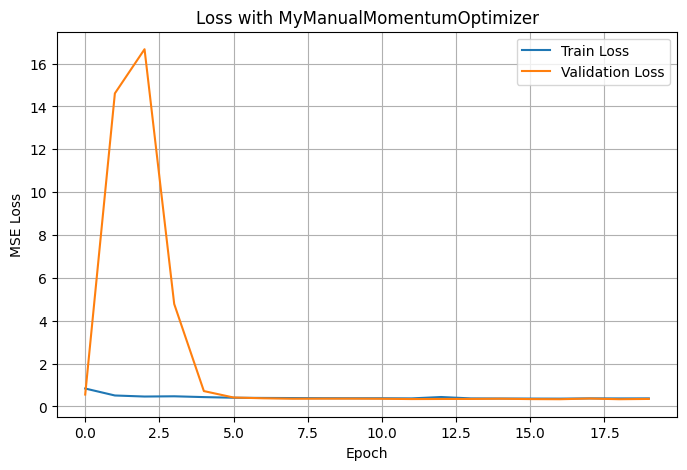

In [15]:
# 6. Plot Losses
plt.figure(figsize=(8,5))
plt.plot(train_losses, label="Train Loss")
plt.plot(valid_losses, label="Validation Loss")
plt.title("Loss with MyManualMomentumOptimizer")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend()
plt.grid(True)
plt.show()

In [16]:
# 7. Evaluate on Test Set
y_test_pred = model.predict(X_test_scaled)
test_loss = loss_fn(y_test, y_test_pred).numpy()
print(f"\nFinal Test Loss: {test_loss:.4f}")

162/162 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step

Final Test Loss: 0.3604


In [17]:
# 8. Save the trained model in the new .keras format

model.save("model_with_manual_momentum.keras")
print(" Model saved as 'model_with_manual_momentum.keras'")


 Model saved as 'model_with_manual_momentum.keras'


In [18]:
# 9. Reload the saved model to verify correctness
# Then evaluate its performance on the test set

reloaded_model = keras.models.load_model("model_with_manual_momentum.keras")
y_test_pred = reloaded_model.predict(X_test_scaled)
reloaded_loss = loss_fn(y_test, y_test_pred).numpy()
print(f"Reloaded Model Test Loss: {reloaded_loss:.4f}")

162/162 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Reloaded Model Test Loss: 0.3604


In [19]:
# 10. Benchmark the custom optimizer against Keras' built-in SGD with momentum

# Clone the original model structure
baseline_model = keras.models.clone_model(model)

# Re-initialize the weights for fair comparison
baseline_model.set_weights([tf.random.normal(w.shape) for w in baseline_model.weights])

# Compile the model using Keras SGD with momentum
baseline_model.compile(
    loss="mse",
    optimizer=keras.optimizers.SGD(learning_rate=0.01, momentum=0.9),
    metrics=["mae"]
)

# Train the model silently
baseline_history = baseline_model.fit(
    X_train_scaled, y_train,
    validation_data=(X_valid_scaled, y_valid),
    epochs=20,
    verbose=0
)

# Evaluate the model on test data
baseline_test_loss = baseline_model.evaluate(X_test_scaled, y_test, verbose=0)
print(f"Keras SGD+Momentum Test Loss: {baseline_test_loss[0]:.4f}, MAE: {baseline_test_loss[1]:.4f}")


Keras SGD+Momentum Test Loss: nan, MAE: nan


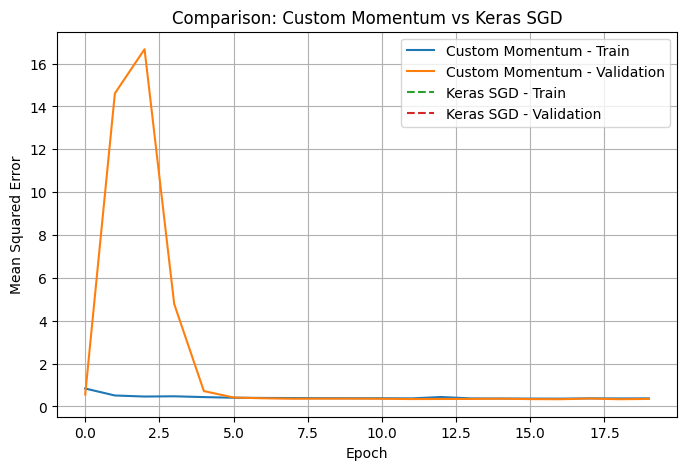

In [20]:
# Plot training and validation losses for both optimizers

plt.figure(figsize=(8, 5))
plt.plot(train_losses, label="Custom Momentum - Train")
plt.plot(valid_losses, label="Custom Momentum - Validation")
plt.plot(baseline_history.history["loss"], "--", label="Keras SGD - Train")
plt.plot(baseline_history.history["val_loss"], "--", label="Keras SGD - Validation")
plt.title("Comparison: Custom Momentum vs Keras SGD")
plt.xlabel("Epoch")
plt.ylabel("Mean Squared Error")
plt.legend()
plt.grid(True)
plt.show()
